In [ ]:
import os
import shutil
import zipfile
from PIL import Image
from distutils.dir_util import copy_tree
from tqdm import tqdm

import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
!cp -r /content/drive/Shareddrives/Sam/Tajik/CarlaEmpty ./

In [ ]:
SRC = './CarlaEmpty'
DEST = './CarlaDS'
IMAGE_SHAPE = (88, 200 , 3)

In [ ]:
extension = ".zip"

for item in os.listdir(SRC):
    if item.endswith(extension):
        file_name = os.path.join(SRC, item)
        zip_ref = zipfile.ZipFile(file_name)
        zip_ref.extractall(SRC)
        zip_ref.close()
        os.remove(file_name)

In [ ]:
folders = os.listdir(SRC)

In [ ]:
csv = os.path.join(SRC, folders[0], 'data.csv')
pd.read_csv(csv)

image_name     steer  throttle  brake      speed  \
0        2022-05-07_10-53-31_220.jpg  0.000000      0.00    0.0   0.000000   
1        2022-05-07_10-53-31_221.jpg  0.000000      0.00    0.0   0.000000   
2        2022-05-07_10-53-31_222.jpg  0.084126      0.85    0.0   0.001653   
3        2022-05-07_10-53-31_223.jpg  0.084126      0.85    0.0   0.001079   
4        2022-05-07_10-53-31_224.jpg  0.084126      0.85    0.0   0.001079   
...                              ...       ...       ...    ...        ...   
24995  2022-05-07_10-53-31_25215.jpg -0.000616      0.85    0.0  16.733900   
24996  2022-05-07_10-53-31_25216.jpg -0.000616      0.85    0.0  16.808855   
24997  2022-05-07_10-53-31_25217.jpg -0.000616      0.85    0.0  16.883207   
24998  2022-05-07_10-53-31_25218.jpg -0.000440      0.85    0.0  16.960585   
24999  2022-05-07_10-53-31_25219.jpg -0.000440      0.85    0.0  17.034376   

                x           y         z        yaw  speed_limit  \
0       92.109978  299.781464  0.001358 -90.000267         30.0   
1       92.109978  299.781464  0.001358 -90.000267         30.0   
2       92.109978  299.781464  0.001330 -90.000267         30.0   
3       92.109978  299.781464  0.001292 -90.000267         30.0   
4       92.109978  299.781464  0.001292 -90.000267         30.0   
...           ...         ...       ...        ...          ...   
24995  130.659409  330.593201  0.001525   0.014762         90.0   
24996  130.964233  330.593323  0.001526   0.013230         90.0   
24997  131.268539  330.593323  0.001526   0.011331         90.0   
24998  131.587265  330.593323  0.001527   0.009175         90.0   
24999  131.893158  330.593353  0.001527   0.007021         90.0   

       is_traffic_light  traffic_light_state  
0                 False                    2  
1                 False                    2  
2                 False                    2  
3                 False                    2  
4                 False                    2  
...                 ...                  ...  
24995             False                    2  
24996             False                    2  
24997             False                    2  
24998             False                    2  
24999             False                    2  

[25000 rows x 12 columns]

In [ ]:
csv = os.path.join(SRC, folders[0], 'data.csv')
df = pd.read_csv(csv)

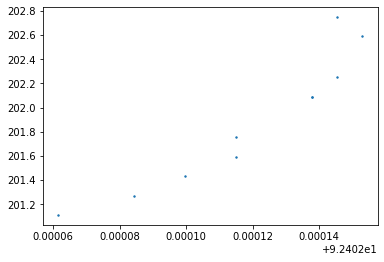

In [ ]:
import matplotlib.pyplot as plt

x = df['x'].to_numpy()
y = df['y'].to_numpy()

idx = 700
plt.scatter(x[idx: idx+10], y[idx:idx+10], s=2)
plt.show()

In [ ]:
def normalize_points(set_of_points, z_rotate):
    yaw = z_rotate * np.pi/180
    s = set_of_points - set_of_points[0]
    # diffs = s[1:] - s[:-1]
    # norm_speed = (speeds[1:] + speeds[:-1])/2
    # norm_diffs = diffs / np.expand_dims(norm_speed, axis=-1)
    # s = np.cumsum(norm_diffs, axis=0)
    R = np.array([[np.cos(yaw), -np.sin(yaw)],
                  [np.sin(yaw), np.cos(yaw)]])
    s = s @ R
    return s

In [ ]:
coordinates = []
controls_labels = []

controls = []
env_controls = []
gps = []
yaws = []
images = []
wps = []

In [ ]:
SKIP_START = 100
FUTURE_FRAMES = 10
FRAME_SKIP_RATE = 4


for folder in tqdm(folders):
    images_dir = os.path.join(SRC, folder, 'images')

    wps_ = np.load(os.path.join(SRC, folder, 'waypoints.npy'))

    csv = os.path.join(SRC, folder, 'data.csv')
    df = pd.read_csv(csv)
    # remove the beginning frames
    length = min(df.shape[0], wps_.shape[0])

    # coordinates_ = df[['x', 'y', 'z']].to_numpy()
    coordinates_ = df[['x', 'y']].to_numpy()
    controls_ = df[['steer', 'throttle', 'brake', 'speed']].to_numpy()
    env_controls_ = df[['speed_limit', 'is_traffic_light', 'traffic_light_state']].to_numpy().astype(float)
    image_names_ = df['image_name'].to_numpy()
    yaws_ = df['yaw'].to_numpy()

    for i in range(SKIP_START, length - FUTURE_FRAMES):
        controls.append(controls_[i-1])
        controls_labels.append(controls_[i])

        cor = normalize_points(coordinates_[i:i+FRAME_SKIP_RATE*FUTURE_FRAMES:FRAME_SKIP_RATE], yaws_[i])
        coordinates.append(cor)

        wp = normalize_points(wps_[i], yaws_[i])
        wps.append(wp)

        env_controls.append(env_controls_[i])

        img = Image.open(os.path.join(images_dir, image_names_[i]))
        img = np.array(img, dtype='uint8')[:, :, 0:3]
        images.append(img)

    shutil.rmtree(os.path.join(SRC, folder), ignore_errors=True)

100%|██████████| 1/1 [00:49<00:00, 49.32s/it]


In [ ]:
controls = np.array(controls)
controls_labels = np.array(controls_labels)
coordinates = np.array(coordinates)
env_controls = np.array(env_controls)
wps = np.array(wps)
images = np.array(images)

In [ ]:
assert controls.shape[0] == controls_labels.shape[0] == coordinates.shape[0] == env_controls.shape[0] == wps.shape[0] == images.shape[0]

In [ ]:
controls.shape, controls_labels.shape, coordinates.shape, env_controls.shape, wps.shape, images.shape

((24782, 4),
 (24782, 4),
 (24782, 10, 2),
 (24782, 3),
 (24782, 10, 2),
 (24782, 88, 200, 3))

In [ ]:
DATA_SIZE = images.shape[0]
PARTS_LEN = 10_000

In [ ]:
indexes = np.arange(DATA_SIZE)
np.random.shuffle(indexes)
print(indexes.shape)
parts = np.array_split(indexes, DATA_SIZE//PARTS_LEN)

(24782,)


In [ ]:
[p.shape for p in parts]

[(12391,), (12391,)]

In [ ]:
os.mkdir(DEST, 0o777)

for i, p in enumerate(parts):
    part_folder = os.path.join(DEST, str(i))
    os.mkdir(part_folder)

    controls_p = controls[p]
    controls_labels_p = controls_labels[p]
    coordinates_p = coordinates[p]
    env_controls_p = env_controls[p]
    wps_p = wps[p]
    images_p = images[p]

    np.save(os.path.join(part_folder, 'controls'), controls_p)
    np.save(os.path.join(part_folder, 'controls_labels'), controls_labels_p)
    np.save(os.path.join(part_folder, 'coordinates'), coordinates_p)
    np.save(os.path.join(part_folder, 'env_controls'), env_controls_p)
    np.save(os.path.join(part_folder, 'wps'), wps_p)
    np.save(os.path.join(part_folder, 'images'), images_p)

In [ ]:
! du -sh ./CarlaDS

1.3G	./CarlaDS


In [ ]:
generated_data = './CarlaDS/0'

In [ ]:
controls = np.load(os.path.join(generated_data, 'controls.npy'))
controls_labels = np.load(os.path.join(generated_data, 'controls_labels.npy'))
coordinates = np.load(os.path.join(generated_data, 'coordinates.npy'))
env_controls = np.load(os.path.join(generated_data, 'env_controls.npy'))
wps = np.load(os.path.join(generated_data, 'wps.npy'))
images = np.load(os.path.join(generated_data, 'images.npy'))

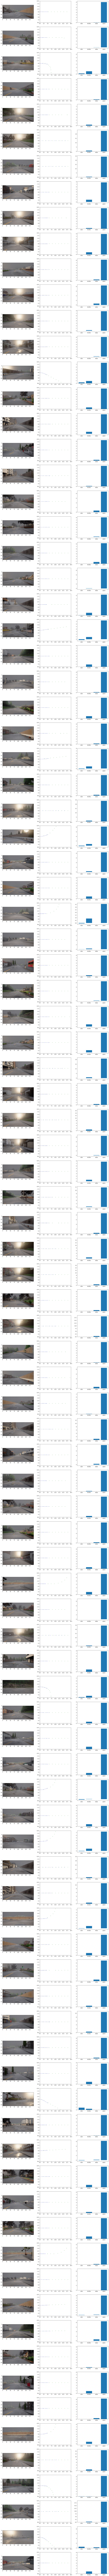

In [ ]:
l = 100
fields = ['steer', 'throttle', 'brake', 'speed']

fig, axes = plt.subplots(l, 3, figsize=(20, l * 5))
for i, (img_ax, ax2, ax3) in enumerate(axes):

    img_ax.imshow(images[i])

    ax2.scatter(coordinates[i, :, 0], coordinates[i, :, 1], s=2, color='b')
    ax2.scatter(wps[i, :, 0], wps[i, :, 1], s=2, color='green')
    ax2.scatter(coordinates[i, 0, 0], coordinates[i, 0, 1], s=2, color='r')
    ax2.set_xlim([0, 20])
    ax2.set_ylim([10,-10])
    
    
    ax3.bar(fields, controls[i])
    # ax3.set_ylim(-1, 1)

In [ ]:
!cp -r CarlaDS /content/drive/Shareddrives/Sam/Datasets/Carla